In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import learning_curve

import pickle

In [57]:
project_accidents_df = pd.read_csv('../data/clean_df.csv')
project_accidents_df = project_accidents_df.sample(20000, random_state=42)

In [58]:
pd.set_option('display.max_columns', None)
project_accidents_df.head(2)

,date,day_of_week,hour,accident_number,road_category,road_layout,num_lanes,reserved_lane,road_profile,road_shape,surface_condition,infrastructure,road_location,speed_limit,injury_severity,users_involved,light_conditions,department,urban_area,intersection_type,weather,collision_type,latitude,longitude,region
26316,2019-01-23,Wednesday,21,201900028031,Local & Access Roads,One Way,4,No value,Flat,Straight,Normal,No value,Road,70,1,3,Night,75,Inside urban area,No junction,Normal,Multi-car collision,48.88343,2.399739,Île-de-France
148184,2021-01-28,Thursday,16,202100051164,Secondary Roads,Two Way,2,No value,Flat,Straight,Normal,No value,Road,50,2,3,Day,63,Inside urban area,No junction,Normal,Multi-car collision,45.87138,3.133130,Auvergne-Rhône-Alpes


In [59]:
X = project_accidents_df.drop(columns=['injury_severity','date', 'accident_number','department', 'latitude', 'longitude', 'region', 'hour', 'users_involved', 'urban_area'])
y = project_accidents_df['injury_severity']


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [60]:
X.shape, y.shape

((20000, 15), (20000,))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [62]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16000, 15), (4000, 15), (16000,), (4000,))

In [63]:
from sklearn.compose import make_column_selector

num_col = make_column_selector(dtype_include=['int64', 'float64'])
cat_col = make_column_selector(dtype_include=['object'])


num_transformer = Pipeline([
    ('standard_scaler', StandardScaler())
])

cat_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor= ColumnTransformer([
    ('num_transformer', num_transformer, num_col),
    ('cat_transformer', cat_transformer, cat_col)
])

In [64]:
preprocessor

,transformers,"[('num_transformer', ...), ('cat_transformer', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


---

## Baseline

In [65]:
project_accidents_df.injury_severity.value_counts(normalize=True)

injury_severity
1    0.7133
2    0.2496
3    0.0371
Name: proportion, dtype: float64

In [66]:
baseline = 0.7133

📝 Baseline accuracy is **0.7133**

## Modeling

###  Default Logistic Regression

In [67]:
# Logistic Regression

model_lr = LogisticRegression(max_iter=1000)

pipeline_lr = make_pipeline(preprocessor, model_lr)
cv_results = cross_val_score(pipeline_lr, X_test, y_test, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.72575)

### Optimize Logistic Regression

In [68]:
params = {
    'logisticregression__C': uniform(0.0001, 10),
    #'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['lbfgs', 'saga'],
}

search_lr = RandomizedSearchCV(
    pipeline_lr,
    params,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42)

search_lr.fit(X, y)
search_lr.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site

{'logisticregression__C': np.float64(5.986684841970366),
 'logisticregression__solver': 'lbfgs'}

In [69]:
best_pipeline_lr = search_lr.best_estimator_

cv_results = cross_val_score(best_pipeline_lr, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.73175)

### Default KNN

In [70]:
# KNN
model_knn = KNeighborsClassifier(n_neighbors=5)

pipeline_knn = make_pipeline(preprocessor, model_knn)
cv_results = cross_val_score(pipeline_knn, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.7025625)

### Optimize KNN

In [71]:
params = {
    "kneighborsclassifier__n_neighbors": randint(1,50),
}

search_knn = RandomizedSearchCV(
                        pipeline_knn,
                        params,
                        n_iter=50,
                        n_jobs=-1,
                        cv=5,
                        scoring='accuracy',
                        verbose=1,
                        random_state=42)

search_knn.fit(X_train,y_train)
search_knn.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'kneighborsclassifier__n_neighbors': 43}

In [72]:
best_pipeline_knn = search_knn.best_estimator_

cv_results = cross_val_score(best_pipeline_knn, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.7301875)

### Default Decision Tree

In [73]:
# Decision Tree
model_tree = DecisionTreeClassifier(max_depth=2, random_state=42)

pipeline_tree = make_pipeline(preprocessor, model_tree)
cv_results = cross_val_score(pipeline_tree, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.7133749999999999)

### Optimize Decision Tree

In [74]:
params = {
    'decisiontreeclassifier__max_depth': randint(2, 20),
    'decisiontreeclassifier__min_samples_split': randint(2, 50),
    'decisiontreeclassifier__min_samples_leaf': randint(1, 20),
    'decisiontreeclassifier__max_features': ['sqrt', 'log2', None],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__class_weight': [None, 'balanced'],
}

search_tree = RandomizedSearchCV(
                        pipeline_tree,
                        params,
                        n_iter=50,
                        n_jobs=-1,
                        cv=5,
                        scoring='accuracy',
                        verbose=1,
                        random_state=42)

search_tree.fit(X_train,y_train)
search_tree.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__min_samples_leaf': 3,
 'decisiontreeclassifier__min_samples_split': 20}

In [75]:
best_pipeline_tree = search_tree.best_estimator_

cv_results = cross_val_score(best_pipeline_tree, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.7293125)

### Default Random Forest

In [76]:
# Random Forest
model_forest = RandomForestClassifier(max_depth=5)

pipeline_forest = make_pipeline(preprocessor, model_forest)
cv_results = cross_val_score(pipeline_forest, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.7285625)

### Optimize Random Forest

In [77]:
params = {
    "randomforestclassifier__n_estimators": randint(50, 300),
    "randomforestclassifier__max_depth": randint(3, 20),
    "randomforestclassifier__min_samples_split": randint(2, 20),
    "randomforestclassifier__min_samples_leaf": randint(1, 10),
    "randomforestclassifier__max_features": ["sqrt", "log2", None],
    "randomforestclassifier__bootstrap": [True, False],
}

search_forest = RandomizedSearchCV(
                        pipeline_forest,
                        params,
                        n_iter=30,
                        n_jobs=-1,
                        cv=5,
                        scoring='accuracy',
                        verbose=1,
                        random_state=42)

search_forest.fit(X_train,y_train)
search_forest.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'randomforestclassifier__bootstrap': False,
 'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__max_features': 'log2',
 'randomforestclassifier__min_samples_leaf': 5,
 'randomforestclassifier__min_samples_split': 14,
 'randomforestclassifier__n_estimators': 90}

In [78]:
best_pipeline_forest = search_forest.best_estimator_

cv_results = cross_val_score(best_pipeline_forest, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.73475)

### Default XGBoost

In [79]:
# XGBoost
model_xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    max_depth=6,
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

pipeline_xgb = make_pipeline(preprocessor, model_xgb)
cv_results = cross_val_score(pipeline_xgb, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.73175)

### Optimize XGBoost

In [80]:
params = {
    'xgbclassifier__max_depth': randint(3, 10),
    'xgbclassifier__n_estimators': randint(50, 300),
    'xgbclassifier__learning_rate': uniform(0.01, 0.3),
    'xgbclassifier__subsample': uniform(0.6, 0.4),          # 0.6～1.0
    'xgbclassifier__colsample_bytree': uniform(0.6, 0.4),    # 0.6～1.0
    'xgbclassifier__gamma': uniform(0, 5),
    'xgbclassifier__min_child_weight': randint(1, 10)
}

search_xgb = RandomizedSearchCV(
                                pipeline_xgb,
                                params,
                                n_iter=50,
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1,
                                verbose=1,
                                random_state=42
                            )

search_xgb.fit(X_train, y_train)
search_xgb.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'xgbclassifier__colsample_bytree': np.float64(0.7123738038749523),
 'xgbclassifier__gamma': np.float64(2.7134804157912424),
 'xgbclassifier__learning_rate': np.float64(0.052277267492428794),
 'xgbclassifier__max_depth': 9,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__n_estimators': 138,
 'xgbclassifier__subsample': np.float64(0.9947547746402069)}

In [81]:
best_pipeline_xgb = search_xgb.best_estimator_

cv_results = cross_val_score(best_pipeline_xgb, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.734875)

### Default SVM

In [82]:
# SVM
model_svm = SVC(kernel='rbf', decision_function_shape='ovr', random_state=42)

pipeline_svm = make_pipeline(preprocessor, model_svm)
cv_results = cross_val_score(pipeline_svm, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.73325)

### Optimize SVM

In [83]:
params = {
    "svc__C": uniform(0.1, 10),
    "svc__gamma": uniform(0.001, 0.1)
}

search_svm = RandomizedSearchCV(
    pipeline_svm,
    params,
    n_iter=20,
    n_jobs=-1,
    cv=5,
    scoring='accuracy',
    verbose=1,
    random_state=42
)

search_svm.fit(X_train, y_train)
search_svm.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/yaeyukimoto/.pyenv/versions/3.12.9/envs/project_accidents/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'svc__C': np.float64(0.7505159298527951),
 'svc__gamma': np.float64(0.09588855372533334)}

In [84]:
best_pipeline_svm = search_svm.best_estimator_

cv_results = cross_val_score(best_pipeline_svm, X_train, y_train, cv=10, scoring='accuracy').mean()
cv_results

np.float64(0.7336250000000001)

## Models with optimized parameters

In [85]:
# Baseline
print('Baseline:            ', baseline, "\n")

# Logistic Regression
print('Logistic Regression: ', cross_val_score(best_pipeline_lr, X_train, y_train, cv=10, scoring='accuracy').mean())

# KNN
print('KNN:                 ', cross_val_score(best_pipeline_knn, X_train, y_train, cv=10, scoring='accuracy').mean())

# Decision Tree
print('Decision Tree:       ', cross_val_score(best_pipeline_tree, X_train, y_train, cv=10, scoring='accuracy').mean())

# Random Forest
print('Random Forest:       ', cross_val_score(best_pipeline_forest, X_train, y_train, cv=10, scoring='accuracy').mean())

# XGBoost
print('XGBoost:             ', cross_val_score(best_pipeline_xgb, X_train, y_train, cv=10, scoring='accuracy').mean())

# SVM
print('SVM:                 ', cross_val_score(best_pipeline_svm, X_train, y_train, cv=10, scoring='accuracy').mean())

Baseline:             0.7133 

Logistic Regression:  0.73175
KNN:                  0.7301875
Decision Tree:        0.7293125
Random Forest:        0.7351875
XGBoost:              0.734875
SVM:                  0.7336250000000001


## Final tests

In [86]:
# Baseline
print('Baseline:            ', baseline, "\n")

# Logistic Regression
print('Logistic Regression: ', best_pipeline_lr.score(X_test,y_test))

# KNN
print('KNN:                 ', best_pipeline_knn.score(X_test,y_test))

# Decision Tree
print('Decision Tree:       ', best_pipeline_tree.score(X_test,y_test))

# Random Forest
print('Random Forest:       ', best_pipeline_forest.score(X_test,y_test))

# XGBoost
print('XGBoost:             ', best_pipeline_xgb.score(X_test,y_test))

# SVM
print('SVM:                 ', best_pipeline_svm.score(X_test,y_test))

Baseline:             0.7133 

Logistic Regression:  0.72925
KNN:                  0.7245
Decision Tree:        0.724
Random Forest:        0.72525
XGBoost:              0.7255
SVM:                  0.72825


---

## Learning curve

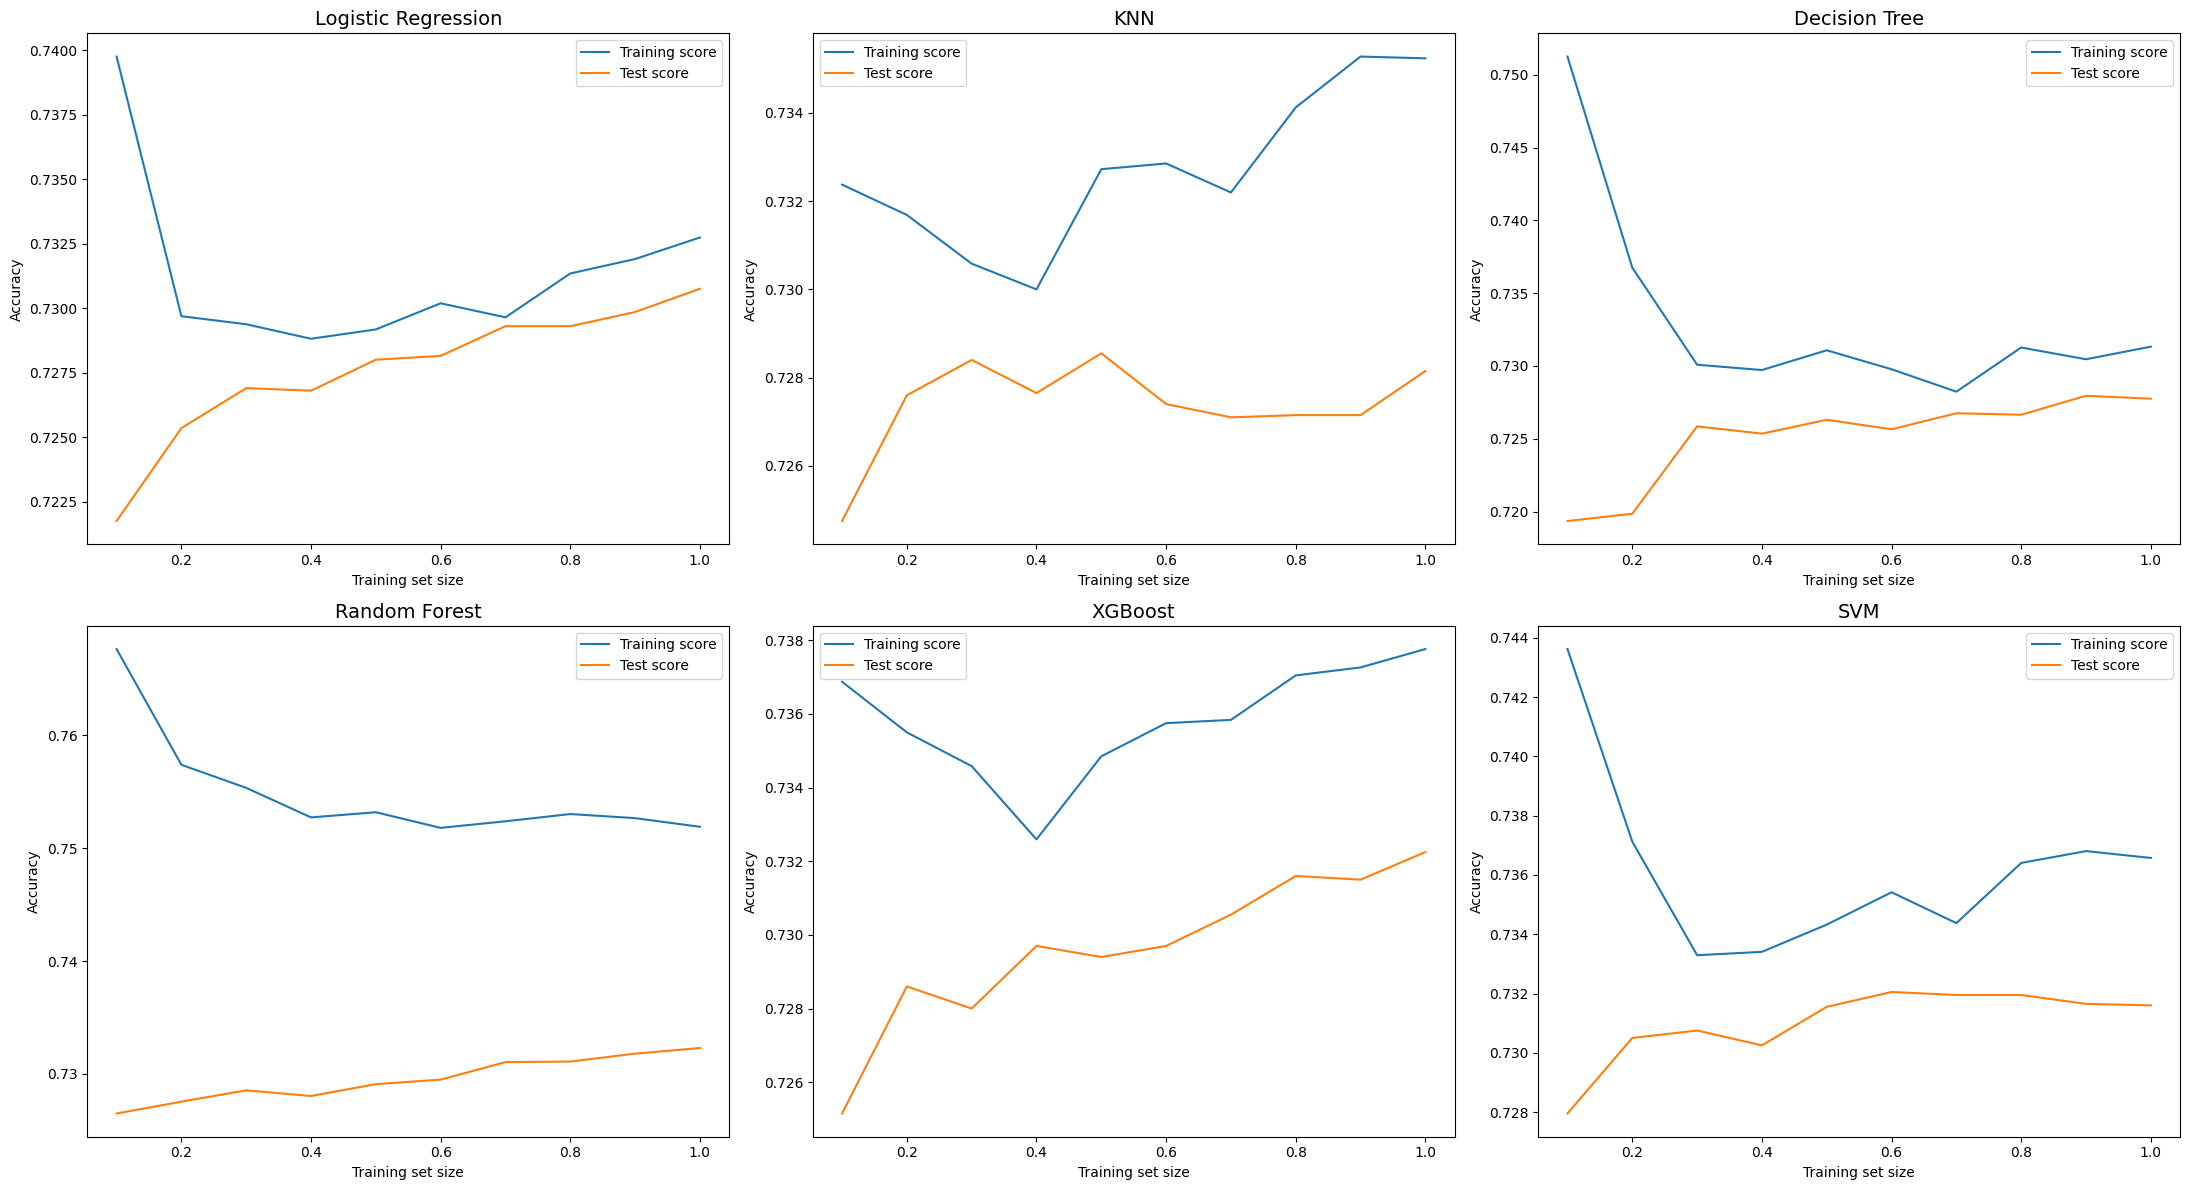

In [87]:
models = {
    'Logistic Regression': best_pipeline_lr,
    'KNN': best_pipeline_knn,
    'Decision Tree': best_pipeline_tree,
    'Random Forest': best_pipeline_forest,
    'XGBoost': best_pipeline_xgb,
    'SVM': best_pipeline_svm
}

fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

train_sizes = np.linspace(0.1, 1.0, 10)

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]

    train_sizes_, train_scores, val_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    ax.plot(train_sizes, train_scores.mean(axis=1), label="Training score")
    ax.plot(train_sizes, val_scores.mean(axis=1), label="Test score")
    ax.set_title(name, fontsize=14)
    ax.set_xlabel("Training set size")
    ax.set_ylabel("Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()

## _

---

In [ ]:
# with open('../models/project_accidents_model.pkl', 'wb') as f:
#     pickle.dump(pipe, f)

In [ ]:
# with open('../models/project_accidents_model.pkl', 'rb') as f:
#     model = pickle.load(f)